# CTR Analysis Ver2

In [1724]:
%reset -f
import numpy as np
from scipy.constants import h, c, e, pi
from scipy.linalg import inv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from fractions import Fraction
import traceback

In [1725]:
exp  = lambda rad: np.exp(rad)
sin  = lambda rad: np.sin(rad)
cos  = lambda rad: np.cos(rad)
tan  = lambda rad: np.tan(rad)
asin = lambda rad: np.arcsin(rad)
acos = lambda rad: np.arccos(rad)
#
sqrt   = lambda vec: np.sqrt(vec)
norm   = lambda vec: np.linalg.norm(vec)
square = lambda vec: np.power(vec, 2)
def vec(*args): return np.array([*args])
def uvec(*args): 
    vec = np.array([*args])
    return  vec / np.linalg.norm(vec)
#
pi   = np.pi
inf  = np.inf
#
eps0 = 8.854187817E-12

In [1726]:
def cube3d(arr, dim=0b001):
    if dim == 0b100:   return np.transpose(np.array(arr),(0, 2, 1))[:,:,::-1]
    elif dim == 0b010: return np.transpose(np.array(arr),(2, 0, 1))[::-1,:,::-1]
    elif dim == 0b001: return np.transpose(np.array(arr),(1, 2, 0))[:,:,::-1]
    else: return

def cuberange(X, Y, Z):
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                yield (i, j, k)

def span(eigenValues, eigenVector):
    return np.tensordot(eigenValues, eigenVector, axes=0)


In [1727]:
def PIticks(start, end, step):
    v = np.arange(start, end+step, step)
    txt = []
    for ii in v:
        f = Fraction(ii)
        if f==0:
            txt.append(0)
            continue
        #
        if   f.numerator ==  1: num = 'π'
        elif f.numerator == -1: num = '-π'
        else: num = f'{f.numerator}π'
        #
        if f.denominator == 1: txt.append(num)
        else : txt.append(f'{num}/{f.denominator}')
    return v*pi, txt

# 
---

In [1728]:
# https://lampz.tugraz.at/~hadley/ss1/crystaldiffraction/atomicformfactors/formfactors.php
AtomicFormFactor = {
	#		a1		b1		a2		b2		a3		b3		a4		b4		c		
	'Sr'  : [17.5663, 1.5564, 9.8184, 14.0988, 5.422, 0.1664, 2.6694, 132.376, 2.5064],
	'Sr2+': [18.0874, 1.4907, 8.1373, 12.6963, 2.5654, 24.5651, -34.193, -0.0138, 41.4025],
	'Ti'  : [9.7595, 7.8508, 7.3558, 0.5, 1.6991, 35.6338, 1.9021, 116.105, 1.2807],
	'Ti2+': [9.11423, 7.5243, 7.62174, 0.457585, 2.2793, 19.5361, 0.087899, 61.6558, 0.897155],
	'Ti3+': [17.7344, 0.22061, 8.73816, 7.04716, 5.25691, -0.15762, 1.92134, 15.9768, -14.652],
    'Ti4+': [19.5114, 0.178847, 8.23473, 6.67018, 2.01341, -0.29263, 1.5208, 12.9464, -13.28],
    'O'   : [3.0485, 13.2771, 2.2868, 5.7011, 1.5463, 0.3239, 0.867, 32.9089, 0.2508],
    'O1-' : [4.1916, 12.8573, 1.63969, 4.17236, 1.52673, 47.0179, -20.307, -0.01404, 21.9412],
	'Ru'  : [19.2674, 0.80852, 12.9182, 8.43467, 4.86337, 24.7997, 1.56756, 94.2928, 5.37874],
    'Ru3+': [18.5638, 0.847329, 13.2885, 8.37164, 9.32602, 0.017662, 3.00964, 22.887, -3.1892],
    'Ru4+': [18.5003, 0.844582, 13.1787, 8.12534, 4.71304, 0.36495, 2.18535, 20.8504, 1.42357],
    'Nd'  : [22.6845, 2.66248, 19.6847, 0.210628, 12.774, 15.885, 2.85137, 137.903, 1.98486],
    'Nd3+': [21.961, 2.52722, 19.9339, 0.199237, 12.12, 14.1783, 1.51031, 30.8717, 1.47588],
    'Ni'  : [12.8376, 3.8785, 7.292, 0.2565, 4.4438, 12.1763, 2.38, 66.3421, 1.0341],
    'Ni2+': [11.4166, 3.6766, 7.4005, 0.2449, 5.3442, 8.873, 0.9773, 22.1626, 0.8614],
    'Ni3+': [10.7806, 3.5477, 7.75868, 0.22314, 5.22746, 7.64468, 0.847114, 16.9673, 0.386044],
    'Ga'  : [15.2354, 3.0669, 6.7006, 0.2412, 4.3591, 10.7805, 2.9623, 61.4135, 1.7189],
    'Ga3+': [12.692, 2.81262, 6.69883, 0.22789, 6.06692, 6.36441, 1.0066, 14.4122, 1.53545]
}

---

In [1729]:
class Lattice:
    def __init__(self, obj, val):
        self.obj = obj
        self.val = val
    def __mul__(self, xray):
        DK = xray.obj.tthetas2dks(xray.val)
        uhkl = uvec(*self.val)
        QQ  = span(DK, uhkl)
        # Q = 2 * pi * hkl / abc
        hkls = QQ * self.obj.abc / 2 / pi
        return hkls
    def __call__(self):
        return self.val

# sto(0,0,1) == Lattice(sto, vec(0,0,1))
# CuKa1(TTHETA) == Lattice(_, TTHETA)

# hkls = sto(0,0,1) * CuKa1(TTHETA)
# 1. 
# dk = TTHETA

# hkls = sto.Gs2hkls(CuKa1.tthetas2dks(TTHETA), nref=vec(0,0,1))

# dk = 2 * self.K * sin(tthetas/2)
# def Gs2hkls(self, G, nref=vec(0,0,1)):
#     nref = uvec(*nref)
#     Qs   = span(G, nref)
#     # Q * abc = 2 * pi * hkl
#     hkls = Qs * self.abc / 2 / pi
#     return hkls

In [1730]:
class Xray():
    CuKa1 = 1.5406
    def __init__(self, wavelength = 1.5406):
        self.wavelength = wavelength # Å unit
        self.K = 2 * pi / wavelength
    def __call__(self, *args):
        if len(args)>0:
            return Lattice(self, *args)
        else: return self.K
    # def G2ttheta(self, G):
    #     return 2 * asin(G / 2 / self.K)
    def tthetas2dks(self, tthetas):
        return 2 * self.K * sin(tthetas/2)

# Usage
CuKa1 = Xray(Xray.CuKa1)

In [1731]:
class Atom():
	def __init__(self, Z, def_name = None):
		self.Z = Z
		if def_name == None:
			(_,_,_,text)=traceback.extract_stack()[-2]
			def_name = text[:text.find('=')].strip()
		self.def_name = def_name

	def __call__(self):
		return self.Z
	def __truediv__(self, num):
		return Atom(self.Z / num.Z, def_name=self.def_name)
	# Atomic Form Factor
	def AFF(self, G, REF = True):
		if REF:
			(a1, b1, a2, b2, a3, b3, a4, b4, c) = AtomicFormFactor[self.def_name]
			return sum(c + vec(*[a * exp(-1 * b * np.power(G/(4*pi), 2)) for a, b in zip(vec(a1, a2, a3, a4), vec(b1, b2, b3, b4))]))
		else:
			return self.Z / np.power(G, 2)

# Usage
Sr = Atom(38)
Ti = Atom(22)
O  = Atom(8)
Ru = Atom(44)
Nd = Atom(60)
Ni = Atom(28)
Ga = Atom(31)

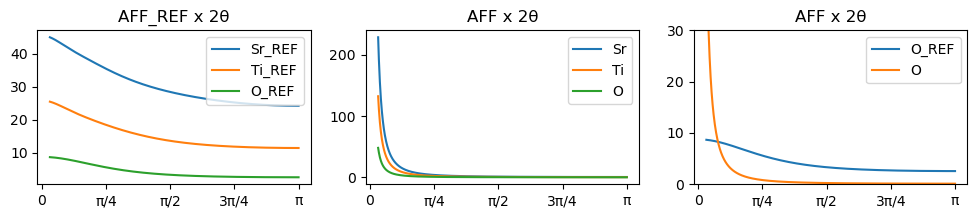

In [1740]:
def EX1():
	TTHETA = np.linspace(0.1, pi, 1000)
	GG = CuKa1.tthetas2dks(TTHETA)
	plt.figure(figsize=(12, 2))
	plt.subplot(1, 3, 1)
	plt.plot(TTHETA, Sr.AFF(GG), label="Sr_REF")
	plt.plot(TTHETA, Ti.AFF(GG), label="Ti_REF")
	plt.plot(TTHETA,  O.AFF(GG), label="O_REF")
	plt.xticks(*PIticks(0, 1, 1/4))
	plt.legend()
	plt.title("AFF_REF x 2θ")
	plt.subplot(1, 3, 2)
	plt.plot(TTHETA, Sr.AFF(GG, False), label="Sr")
	plt.plot(TTHETA, Ti.AFF(GG, False), label="Ti")
	plt.plot(TTHETA,  O.AFF(GG, False), label="O")
	plt.xticks(*PIticks(0, 1, 1/4))
	plt.legend()
	plt.title("AFF x 2θ")
	plt.subplot(1, 3, 3)
	plt.plot(TTHETA,  O.AFF(GG), label="O_REF")
	plt.plot(TTHETA,  O.AFF(GG, False), label="O")
	plt.xticks(*PIticks(0, 1, 1/4))
	plt.legend()
	plt.title("AFF x 2θ")
	plt.ylim([0,30])
EX1()

In [1733]:
class Molecule():
    def __init__(self, structure, abc):
        self.structure = structure
        self.abc = vec(*abc)
    def __call__(self, *args):
        if len(args) > 0:
            return Lattice(self, vec(*args))
        else:
            return self.abc
    #
    def perovskite(A, B, O): # Atoms
        A /= Atom(8)
        O /= Atom(2)
        return cube3d([
            [[A, 0, A], [0, O, 0], [A, 0, A]],
            [[0, O, 0], [O, B, O], [0, O, 0]],
            [[A, 0, A], [0, O, 0], [A, 0, A]]
        ], 0b100)
    def pseudocubic(*abc):
        a, b, c = abc
        ac      = np.sqrt(a**2 + b**2) / 2
        cc      = c / 2
        return np.array((ac, ac, cc))
    def const_volume_abc(self, film_abc):
        a, b, _ = self.abc
        return np.array([a, b, np.prod(film_abc) / (a*b)])
    def strain(self, film):
        return Molecule(
			structure = film.structure,
			abc = self.const_volume_abc(film.abc)
		)
    def __truediv__(self, substrate):
        return Molecule(
			structure = self.structure,
			abc = substrate.const_volume_abc(self.abc)
    )
    #
    def Gs2hkls(self, G, nref=vec(0,0,1)):
        nref = uvec(*nref)
        Qs   = span(G, nref)
        # Q * abc = 2 * pi * hkl
        hkls = Qs * self.abc / 2 / pi
        return hkls
    # def hkls2Gs(self, hkls):
    #     return np.linalg.norm(2 * pi * hkls / self.abc , axis = 1)

    # Structure Factor
    def SF(self, hkls, REF = True):
        # TTHETA = np.linspace(0.1, pi, 1000)
        G = np.linalg.norm(2 * pi * hkls / self.abc, axis = 1)
        (Nx, Ny, Nz) = len(self.structure[:,0,0]),len(self.structure[0,:,0]),len(self.structure[0,0,:])
        sf = np.zeros(len(hkls))
        for (ii,jj,kk) in cuberange(Nx,Ny,Nz):
            if self.structure[ii,jj,kk]==0 : continue
            # rj는 sample의 abc 프레임 기준..
            rj = vec(ii,jj,kk) / vec(Nx-1, Ny-1, Nz-1) 
            sf = sf + self.structure[ii,jj,kk].AFF(G, REF) * exp(2j * pi * hkls @ rj)
        return sf

# Usage
sto = Molecule(
    structure = Molecule.perovskite(Sr, Ti, O),
    abc = (3.905, 3.905, 3.905)
)
sro = Molecule(
    structure = Molecule.perovskite(Sr, Ru, O),
    abc = Molecule.pseudocubic(5.567, 5.5304, 7.8446)
)
nno = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.387, 5.383, 7.610)
)
ngo = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.428, 5.498, 7.708)
)
sro_sto = sro/sto # sto.strain(sro)
nno_sto = nno/sto # sto.strain(nno)
ngo_sto = ngo/sto # sto.strain(ngo)
#
np.abs(sto.SF(   # 00l scan Reflection
    hkls    = vec([0, 0, 1], [0, 0, 2]), 
))

array([287.83372083, 332.20869193])

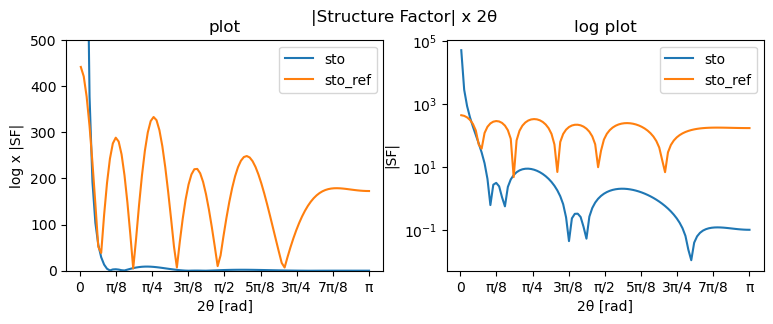

In [1734]:
def EX2():
    TTHETA = np.linspace(0.01, pi, 100)
    hkls = sto(0,0,1)*CuKa1(TTHETA)
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    plt.plot(TTHETA, np.abs(sto.SF(hkls, False)), label = 'sto')
    plt.plot(TTHETA, np.abs(sto.SF(hkls)), label = 'sto_ref')
    plt.xticks(*PIticks(0, 1, 1/8))
    plt.legend()
    plt.ylim([0, 500])
    plt.xlabel('2θ [rad]')
    plt.ylabel('log x |SF|')
    plt.title('plot')
    plt.subplot(1,2,2)
    plt.semilogy(TTHETA, np.abs(sto.SF(hkls, False)), label = 'sto')
    plt.semilogy(TTHETA, np.abs(sto.SF(hkls)), label = 'sto_ref')
    plt.legend()
    plt.title('log plot')
    plt.xticks(*PIticks(0, 1, 1/8))
    plt.xlabel('2θ [rad]')
    plt.ylabel('|SF|')
    plt.suptitle(f"|Structure Factor| x 2θ")
EX2()
# G(=|Q|)가 너무 크면 CuKa1의 𝚫k로 만들어 낼 수 없어서 (사소한 ~ 해결할 필요가 없는) 오류 발생!
# Xray와, 샘플들에서 (𝚫k = Q)가 가능한 hkl 교집합을 찾는 함수를 만들면 해결할 수는 있다.

In [1735]:
# def orthogonal(v):
#     cnt = len(*np.where(v == 0))
#     u = vec(0,0,0)
#     if cnt == 0:
#         h, k, _ = v
#         return uvec(1/h, -1/k, 0)
#     elif cnt == 1:
#         u[np.where(v == 0)[0][0]] = 1
#         return u
#     elif cnt == 2:
#         u[np.where(v == 0)[0]] = 1
#         return uvec(*u)
#     else:
#         return uvec(1,1,1)
    
# def ttheta2ki(ttheta, hkl):
#     u  = orthogonal(hkl)
#     v  = hkl + u * norm(hkl) * tan((pi - ttheta)/2)
#     return -K * uvec(*v)

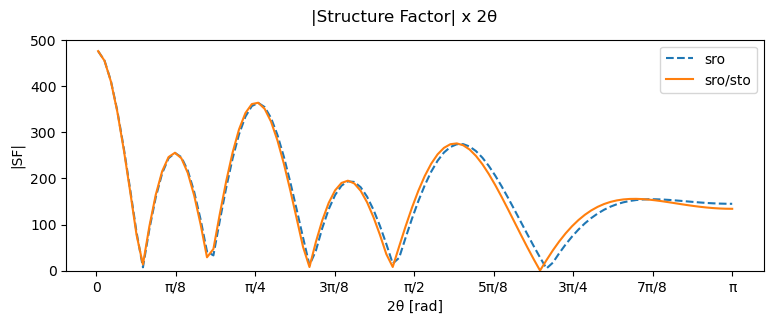

In [1736]:
def EX3():
    TTHETA = np.linspace(0.01, pi, 100)
    sro_hkls     = sro(0,0,1)*CuKa1(TTHETA)
    sro_sto_hkls = sro_sto(0,0,1)*CuKa1(TTHETA)
    
    plt.figure(figsize=(9,3))
    plt.plot(TTHETA, np.abs(sro.SF(sro_hkls)), label = 'sro', linestyle='dashed')
    plt.plot(TTHETA, np.abs(sro_sto.SF(sro_sto_hkls)), label = 'sro/sto')
    plt.xticks(*PIticks(0, 1, 1/8))
    plt.legend()
    plt.ylim([0, 500])
    plt.xlabel('2θ [rad]')
    plt.ylabel('|SF|')
    plt.suptitle(f"|Structure Factor| x 2θ")
EX3()

In [1737]:
# def orthogonal(v):
#     cnt = len(*np.where(v == 0))
#     u = vec(0,0,0)
#     if cnt == 0:
#         h, k, _ = v
#         return uvec(1/h, -1/k, 0)
#     elif cnt == 1:
#         u[np.where(v == 0)[0][0]] = 1
#         return u
#     elif cnt == 2:
#         u[np.where(v == 0)[0]] = 1
#         return uvec(*u)
#     else:
#         return uvec(1,1,1)
    
# def ttheta2ki(ttheta, hkl):
#     u  = orthogonal(hkl)
#     v  = hkl + u * norm(hkl) * tan((pi - ttheta)/2)
#     return -K * uvec(*v)

In [1738]:
class Film():
    def __init__(self, molecule, NaNbNc, configuration = []):
        self.molecule = molecule
        self.NaNbNc = NaNbNc
        self.Na, self.Nb, self.Nc = NaNbNc
        self.configuration = configuration
    def __call__(self):
        return self.molecule()
    def __truediv__(self, substrate):
        return Film(self.molecule, self.NaNbNc, [*self.configuration, substrate])
    

class Sample():
    def __init__(self, top_film):
        if top_film.configuration == []:
            self.films = [top_film]
        else:
            self.films = [top_film, *top_film.configuration]
        self.bulk = self.films.pop()
    def __call__(self):
        return vec(*[x() for x in self.films], self.bulk())

# Usage
STO = Film(sto, (10, 10, 100))
SRO = Film(sro, (10, 10, 10))
NNO = Film(nno, (10, 10, 10))
NGO = Film(ngo, (10, 10, 10))
#
NNO_SRO_STO = Sample(NNO/SRO/STO)
# SAMP = Sample(SRO)
print('Total Configuration )')
print(NNO_SRO_STO())
print(f'BULK ) \n{NNO_SRO_STO.bulk()}')
print(f'FILM ) \n{vec(*[x() for x in NNO_SRO_STO.films])}')

Total Configuration )
[[3.80777028 3.80777028 3.805     ]
 [3.92354474 3.92354474 3.9223    ]
 [3.905      3.905      3.905     ]]
BULK ) 
[3.905 3.905 3.905]
FILM ) 
[[3.80777028 3.80777028 3.805     ]
 [3.92354474 3.92354474 3.9223    ]]
